In [1]:
import torch
import torchvision.transforms as transforms
from utils import *
from models import *

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [24]:
test_transform = transforms.Compose([transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
# test_transform = transforms.Compose([transforms.ToTensor()
# ])
test_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
#     transforms.RandomCrop(32, padding=4),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
test_data = torchvision.datasets.CIFAR10('data/', download=True, train=False, transform=test_transform)
test_dataloader = torch.utils.data.DataLoader(test_data,
                                          batch_size=4096, # just for test accuracy
                                          shuffle=True)

cifar_labels = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

Files already downloaded and verified


In [12]:
model = ResNet('50').to(device)
model.load_state_dict(torch.load('adv_resnet50'))
model.eval()
print()

Using cache found in C:\Users\Oliver/.cache\torch\hub\pytorch_vision_v0.6.0


In [1]:
# test_acc = accuracy(model, test_dataloader, device)
# fgsm_acc = fgsm_accuracy(model, test_dataloader, device)
# pgd_acc = pgd_accuracy(model, test_dataloader, device, eps=10, steps=3, alpha=0.1)
# print('Normal Test Accuray:', test_acc)
# print('FGSM Test Accuracy:', fgsm_acc)
# print('PGD Test Accuracy:', pgd_acc)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


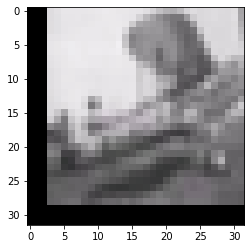

In [39]:
it = iter(test_dataloader)
image, label = it.next()
image, label = image[0].to(device), label[0].view(1).to(device)
display_im(image.cpu())


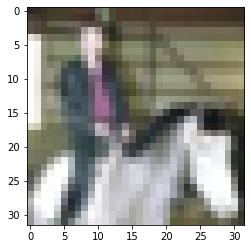

horse
dog
tensor(-2.0608, device='cuda:0') tensor(2.7537, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.6000, device='cuda:0') tensor(0.6000, device='cuda:0')
dog


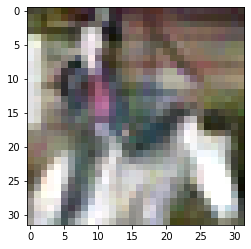

In [46]:
display_im(image.cpu())
print(cifar_labels[label.item()])
print(cifar_labels[torch.argmax(model(image.view(-1,3,32,32))).item()])
print(torch.min(image), torch.max(image))
# adv = pgd(image.view(1,3,32,32), label, model, stepsize=0.1, eps=50, steps=5, constraint='l_2')
adv = pgd(image.view(1,3,32,32), label, model, stepsize=.015, eps=.6, steps=40, constraint='l_inf')
# adv = pgd(image.view(1,3,32,32), label, model, stepsize=.03, eps=.1, steps=5, constraint='l_inf')

# adv = fgsm(image.view(1, 3, 32, 32), label, model, eps=.2)
# adv = pgd_attack(image.view(3,32,32), 5, model, stepsize=1, eps=60, steps=80, constraint='l_2')

# print(torch.max(image - adv))
# print(adv.shape)
print(torch.min(image - adv), torch.max(image - adv))
print(cifar_labels[torch.argmax(model(adv)).item()])
display_im(adv.view(3,32,32).cpu())

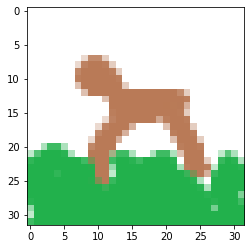

torch.Size([1, 3, 32, 32]) torch.Size([1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


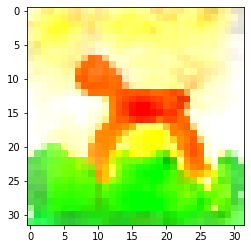

deer


In [47]:
import imageio
image = torch.Tensor(imageio.imread('frog.png')).permute(2, 0, 1).to(device) / 255.
# print(image.shape)
plt.imshow(image.permute(1, 2, 0).cpu())
plt.show()
label = torch.Tensor([6]).cuda().long()
# adv = pgd(image.view(1,3,32,32), label, model, stepsize=1, eps=60, steps=80, constraint='l_2')
# adv = pgd(image.view(1,3,32,32), label, model, stepsize=.015, eps=.6, steps=40, constraint='l_inf')
# adv = pgd(image.view(1,3,32,32), label, model, stepsize=.03, eps=.1, steps=5, constraint='l_inf')

# adv = fgsm(image.view(1, 3, 32, 32), label, model, eps=0.2)
adv = pgd_attack(image.view(3,32,32), 4, model, stepsize=2, eps=100, steps=50, constraint='l_2')
plt.imshow(adv.cpu().view(3, 32, 32).permute(1, 2, 0))
plt.show()
print(cifar_labels[torch.argmax(model(adv.view(1, 3, 32, 32))).item()])
